In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("insurance_cleaned_addcols.csv")
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,age_car_incident,age_policy_incident,workshop,adjuster
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,1,1,2,1,71610,6510,13020,52080,Saab,92x,2004,1,11,1,A,Frank
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,Front Collision,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,1,0,0,1,5070,780,780,3510,Mercedes,E400,2007,1,8,9,A,Frank
2,134,29,687698,2000-06-09,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,0,2,3,0,34650,7700,3850,23100,Dodge,RAM,2007,0,8,15,A,Frank
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-10-01,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,0,1,2,0,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1,1,25,C,Harry
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,Front Collision,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,0,0,1,0,6500,1300,650,4550,Accura,RSX,2009,0,6,1,C,Harry


In [3]:
non_numerical_cols = []
numerical_cols = []
for col in df.columns:
    if (df[col].dtype != np.int64 and df[col].dtype != np.float64):
        non_numerical_cols.append(col)
    else:
        numerical_cols.append(col)
numerical_cols.append('policy_bind_date')
categorical = df[non_numerical_cols[1:]]
numerical_cols.remove('fraud_reported')
numerical = df[numerical_cols].copy()
new_categorical = categorical.copy()

date_str_to_num = lambda string: (int(string[:4]) - 1990) + int(string[5:7])/12 + int(string[-2:])/(12 * 30)
for i in range(1000):
    numerical['policy_bind_date'][i] = date_str_to_num(df['policy_bind_date'][i])
for col in categorical.columns:
    uniques = categorical[col].unique()
    new_col = []
    for i in range(1000):
        n = len(uniques)
        for j in range(n):
            if (categorical[col][i] == uniques[j]):
                new_col.append(j)
                break
    new_categorical[col] = new_col
categorical = new_categorical

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [4]:
array = np.zeros((1000,categorical.max().sum() + len(categorical.columns)))
index = 0
def oneHot(val, maxVal):
    output = [0]*maxVal
    output[val] = 1
    return output
for col in categorical.columns:
    num = categorical[col].max() + 1
    arr = np.zeros((1000,num))
    for i in range(1000):
        arr[i] = oneHot(categorical[col][i], num)
    array[:, index:index+num] = arr
    index += num

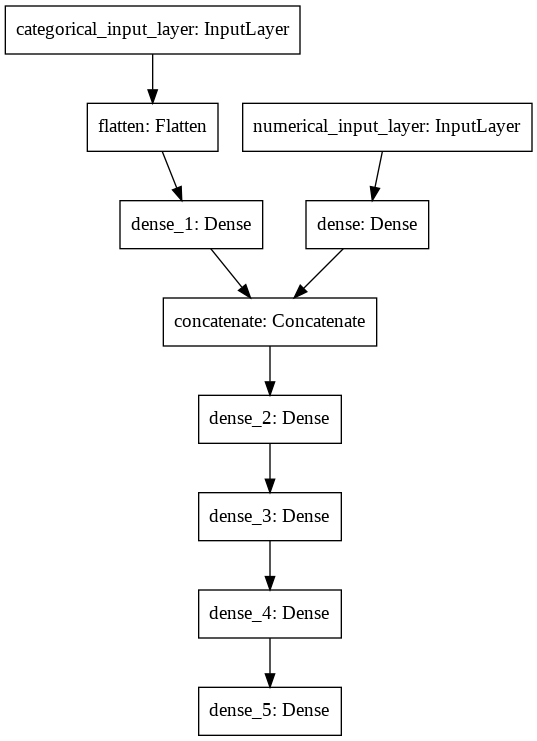

In [5]:
inputs_numerical = keras.Input(shape=(len(numerical_cols)), name = 'numerical_input_layer')
dense_numerical = layers.Dense(30, activation='relu')(inputs_numerical)


inputs_categorical = keras.Input(shape=(array.shape[1]), name = 'categorical_input_layer')
flatten_categorical = layers.Flatten()(inputs_categorical)
dense_categorical = layers.Dense(30, activation='relu')(flatten_categorical)

flatten_combined = layers.Concatenate()([dense_numerical, dense_categorical])
dense_combined = layers.Dense(60, activation='relu')(flatten_combined)
dense_combined = layers.Dense(60, activation='relu')(dense_combined)
dense_combined = layers.Dense(60, activation='relu')(dense_combined)
outputs = layers.Dense(1, activation='sigmoid')(dense_combined)
model = keras.Model(inputs=[inputs_numerical, inputs_categorical], outputs=outputs)

model.compile(optimizer="Adam", loss="binary_crossentropy",metrics = ['accuracy'])

keras.utils.plot_model(model)

In [6]:
bestValLoss = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
    )


hist = model.fit([np.array(numerical).astype(float), array], np.array(df['fraud_reported']), 
                 epochs=1000, 
                 validation_split = 0.1,
                 callbacks = [bestValLoss],
                )
results = pd.DataFrame(hist.history)
results.to_csv('results.csv')
model.save("bestValLoss.hdf5")

Epoch 1/1000
29/29 [==============================] - 1s 18ms/step - loss: 21399.0277 - accuracy: 0.6039 - val_loss: 6765.5029 - val_accuracy: 0.7000
Epoch 2/1000
29/29 [==============================] - 0s 5ms/step - loss: 4368.9340 - accuracy: 0.6157 - val_loss: 2764.5259 - val_accuracy: 0.6000
Epoch 3/1000
29/29 [==============================] - 0s 4ms/step - loss: 5799.8387 - accuracy: 0.6606 - val_loss: 2778.6230 - val_accuracy: 0.7800
Epoch 4/1000
29/29 [==============================] - 0s 4ms/step - loss: 1963.8595 - accuracy: 0.6696 - val_loss: 1090.4550 - val_accuracy: 0.5900
Epoch 5/1000
29/29 [==============================] - 0s 4ms/step - loss: 1600.1894 - accuracy: 0.5481 - val_loss: 5233.7808 - val_accuracy: 0.7900
Epoch 6/1000
29/29 [==============================] - 0s 4ms/step - loss: 3634.3541 - accuracy: 0.6698 - val_loss: 1037.3013 - val_accuracy: 0.5100
Epoch 7/1000
29/29 [==============================] - 0s 4ms/step - loss: 853.2414 - accuracy: 0.6071 - val_lo

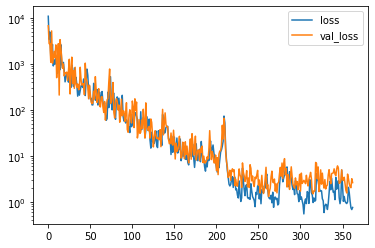

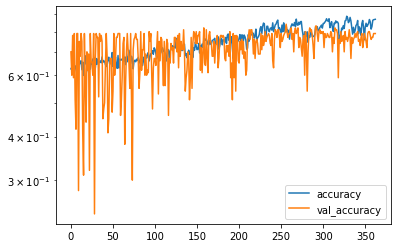

In [7]:
results[['loss','val_loss']].plot(logy=True)
results[['accuracy','val_accuracy']].plot(logy=True)

In [8]:
results

,loss,accuracy,val_loss,val_accuracy
0,10910.627930,0.625556,6765.502930,0.70
1,3439.213623,0.632222,2764.525879,0.60
2,4933.142090,0.632222,2778.623047,0.78
3,1408.726440,0.652222,1090.454956,0.59
4,1633.404907,0.610000,5233.780762,0.79
...,...,...,...,...
358,1.574494,0.827778,2.476968,0.77
359,1.034855,0.862222,2.135543,0.77
360,0.741808,0.865556,2.036189,0.79
361,0.681191,0.866667,3.190736,0.79
